In [ ]:
!pip install glob2 seaborn opencv-python rasterio

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import these modules:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import imageio
import glob
import cv2
import seaborn as sns
sns.set(style="ticks", color_codes=True)
import rasterio
from sklearn.cluster import KMeans
from matplotlib.colors import ListedColormap
from scipy.spatial.distance import cdist

In [ ]:
########## USER MUST DEFINE THESE ###########
image_folder_header = '/content/drive/MyDrive/landcover/analysis/' # subfolder where images are located
image_format = 'tif' # format of image files (the exact suffix of the filenames)
folder_name = ['2013','2017', '2021']
band_names = ['B1','B2','B3','B4','B5','B6','B7'] # names of bands (in file names). should all have some length
Nsamples = 20000 #  number of random samples used to "train" k-means here (for faster execution)

In [ ]:
# import images to dictionary:
images = dict()
for image_path in glob.glob(image_folder_header+folder_name[2]+'/*.'+image_format):
    print('reading ',image_path)
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    temp = cv2.normalize(img,  img, 0, 255, cv2.NORM_MINMAX)
    print(temp)
    images[image_path[96:98]] = temp # FOR DIFFERENT FILE NAMES, ADJUST THIS!
    print('images have', np.size(temp),'pixels each')

reading  /content/drive/MyDrive/landcover/analysis/2021/RT_clip_LC08_L1TP_126046_20200824_20200905_01_T1_B1.tif
[[36 36 18 ... 18 18 18]
 [36 36 36 ... 18 18 18]
 [18 18 18 ... 18 18 18]
 ...
 [ 0  0 18 ...  0  0 18]
 [ 0  0 18 ...  0  0 18]
 [ 0  0  0 ... 18 18 18]]
images have 590944 pixels each
reading  /content/drive/MyDrive/landcover/analysis/2021/RT_clip_LC08_L1TP_126046_20200824_20200905_01_T1_B3.tif
[[40 40 40 ... 27 27 27]
 [40 40 40 ... 27 27 27]
 [27 27 40 ... 27 27 27]
 ...
 [27 27 27 ... 13 13 27]
 [27 27 27 ... 13 13 27]
 [27 27 27 ... 27 27 27]]
images have 590944 pixels each
reading  /content/drive/MyDrive/landcover/analysis/2021/RT_clip_LC08_L1TP_126046_20200824_20200905_01_T1_B4.tif
[[49 36 36 ... 36 24 36]
 [36 36 36 ... 24 36 36]
 [24 24 24 ... 24 24 24]
 ...
 [12 12 24 ...  0 12 24]
 [12 12 24 ... 12 12 24]
 [24 24 24 ... 24 24 36]]
images have 590944 pixels each
reading  /content/drive/MyDrive/landcover/analysis/2021/RT_clip_LC08_L1TP_126046_20200824_20200905_01_T

In [ ]:
# make a 3D numpy array of data...
imagecube = np.zeros([images['B1'].shape[0],images['B1'].shape[1],np.size(band_names)])
for j in np.arange(np.size(band_names)):
    imagecube[:,:,j] = images[band_names[j]] 
imagecube=imagecube/255 #  scaling to between 0 and 1

In [ ]:
print(imagecube)

[[[0.14117647 0.18823529 0.15686275 ... 0.42352941 0.35686275 0.29019608]
  [0.14117647 0.1254902  0.15686275 ... 0.50196078 0.28627451 0.20784314]
  [0.07058824 0.1254902  0.15686275 ... 0.4627451  0.28627451 0.16470588]
  ...
  [0.07058824 0.0627451  0.10588235 ... 0.34509804 0.32156863 0.25098039]
  [0.07058824 0.0627451  0.10588235 ... 0.38431373 0.32156863 0.25098039]
  [0.07058824 0.0627451  0.10588235 ... 0.38431373 0.35686275 0.29019608]]

 [[0.14117647 0.1254902  0.15686275 ... 0.4627451  0.35686275 0.25098039]
  [0.14117647 0.1254902  0.15686275 ... 0.5372549  0.28627451 0.16470588]
  [0.14117647 0.1254902  0.15686275 ... 0.5372549  0.28627451 0.16470588]
  ...
  [0.07058824 0.0627451  0.10588235 ... 0.34509804 0.25098039 0.20784314]
  [0.07058824 0.0627451  0.10588235 ... 0.38431373 0.32156863 0.29019608]
  [0.07058824 0.0627451  0.10588235 ... 0.38431373 0.35686275 0.33333333]]

 [[0.07058824 0.0627451  0.10588235 ... 0.57647059 0.28627451 0.16470588]
  [0.07058824 0.062745

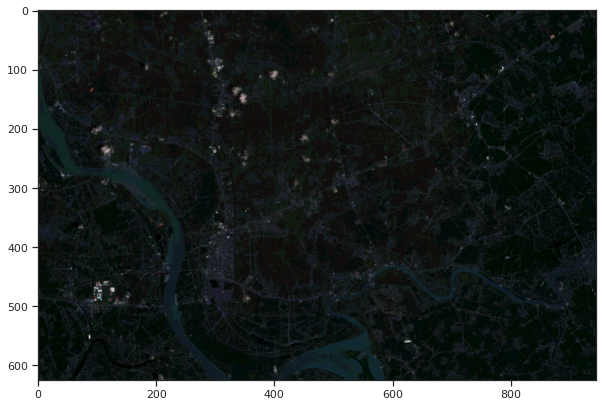

In [ ]:
# display an RGB or false colour image
thefigsize = (10,8)# set figure size
plt.figure(figsize=thefigsize)
plt.imshow(imagecube[:,:,1:4])

In [ ]:
# sample random subset of images
imagesamples = []
for i in range(Nsamples):
    xr=np.random.randint(0,imagecube.shape[1]-1)
    yr=np.random.randint(0,imagecube.shape[0]-1)
    imagesamples.append(imagecube[yr,xr,:])
#convert to pandas dataframe
imagessamplesDF=pd.DataFrame(imagesamples,columns = band_names)
print(imagessamplesDF)

             B1        B2        B3        B4        B5        B6        B7
0      0.000000  0.000000  0.050980  0.047059  0.384314  0.141176  0.082353
1      0.141176  0.125490  0.156863  0.141176  0.384314  0.356863  0.290196
2      0.070588  0.062745  0.156863  0.192157  0.039216  0.035294  0.000000
3      0.141176  0.125490  0.105882  0.094118  0.501961  0.250980  0.125490
4      0.286275  0.250980  0.211765  0.192157  0.576471  0.321569  0.207843
...         ...       ...       ...       ...       ...       ...       ...
19995  0.070588  0.062745  0.105882  0.094118  0.423529  0.215686  0.125490
19996  0.141176  0.125490  0.156863  0.141176  0.305882  0.180392  0.164706
19997  0.070588  0.062745  0.050980  0.094118  0.384314  0.215686  0.125490
19998  0.070588  0.062745  0.105882  0.094118  0.345098  0.215686  0.125490
19999  0.070588  0.062745  0.105882  0.141176  0.113725  0.035294  0.000000

[20000 rows x 7 columns]


In [ ]:
# fit kmeans to samples:
KMmodel = KMeans(n_clusters=3) 
KMmodel.fit(imagessamplesDF)

KMeans(n_clusters=3)

In [ ]:
#  make the clustered image
imageclustered=np.empty((imagecube.shape[0],imagecube.shape[1]))
i=0
for row in imagecube:
    temp = KMmodel.predict(row) 
    imageclustered[i,:]=temp
    i=i+1

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/pytho

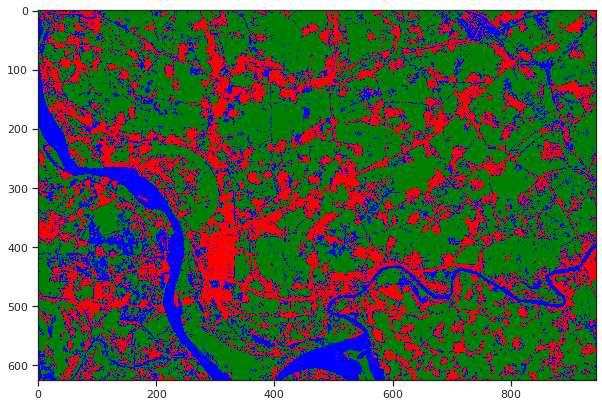

In [ ]:
# plot the map of the clustered data
plt.figure(figsize=thefigsize)
plt.imshow(imageclustered, cmap=ListedColormap(['red','blue','green'])) 

In [ ]:
plt.imsave('/content/drive/MyDrive/landcover/analysis/2021/image_KMean_sklearn.jpg',imageclustered, cmap=ListedColormap(['red','blue','green']))

In [ ]:
# import images to dictionary:
imagecube = []
images = dict()
for i in range(np.size(folder_name)):
    for image_path in glob.glob(image_folder_header + folder_name[i] +'/*.'+image_format):
        print('reading ',image_path)
        temp = rasterio.open(image_path)
        temp = temp.read(1)
        print(temp)
        images[image_path[96:98]] = temp
    # make a 3D numpy array of data...
    image_matrix = np.zeros([images['B1'].shape[0],images['B1'].shape[1],np.size(band_names)])
    for j in np.arange(np.size(band_names)):
        image_matrix[:,:,j] = images[band_names[j]] 
    imagecube.append(image_matrix)
imagecube = np.array(imagecube)

reading  /content/drive/MyDrive/landcover/analysis/2013/RT_clip_LC08_L1TP_126046_20130922_20170502_01_T1_B1.tif
[[340 319 291 ... 241 269 267]
 [235 235 280 ... 253 259 242]
 [225 233 240 ... 233 211 198]
 ...
 [147 142 147 ... 134 131 137]
 [139 135 136 ... 145 140 149]
 [133 133 134 ... 178 152 173]]
reading  /content/drive/MyDrive/landcover/analysis/2013/RT_clip_LC08_L1TP_126046_20130922_20170502_01_T1_B4.tif
[[672 545 534 ... 374 529 473]
 [311 345 480 ... 394 387 337]
 [260 290 364 ... 407 262 179]
 ...
 [350 341 328 ... 196 194 213]
 [320 316 303 ... 277 234 261]
 [274 277 282 ... 434 303 346]]
reading  /content/drive/MyDrive/landcover/analysis/2013/RT_clip_LC08_L1TP_126046_20130922_20170502_01_T1_B3.tif
[[493 430 430 ... 303 364 347]
 [331 316 421 ... 323 318 297]
 [324 302 316 ... 332 242 178]
 ...
 [216 210 201 ... 246 237 235]
 [198 198 189 ... 270 255 276]
 [189 184 189 ... 317 274 307]]
reading  /content/drive/MyDrive/landcover/analysis/2013/RT_clip_LC08_L1TP_126046_2013092

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  app.launch_new_instance()


In [ ]:
centroids_init = [[[ 267,  314,  454,  641,  147,  110,  119],
                  [ 189,  170,  264,  195, 2724, 1409,  643],
                  [ 299,  310,  371,  565, 1492, 2140, 1736],
                  [ 231,  275,  399,  625, 1852, 2088, 1310]],
                  [[ 267,  314,  454,  641,  147,  110,  119],
                  [ 147,  142,  205,  162, 2979, 1663,  758],
                  [ 390,  439,  444,  743, 1426, 2445, 2103],
                  [ 297,  359,  464,  778, 1733, 2277, 1578]],
                  [[ 267,  314,  454,  641,  147,  110,  119],
                  [ 189,  170,  264,  195, 2724, 1409,  643],
                  [ 299,  310,  371,  565, 1492, 2140, 1736],
                  [ 231,  275,  399,  625, 1852, 2088, 1310]]
                  ]
# convert to pandas dataframe
centroids_init = np.array(centroids_init)
print(centroids_init)

[[[ 267  314  454  641  147  110  119]
  [ 189  170  264  195 2724 1409  643]
  [ 299  310  371  565 1492 2140 1736]
  [ 231  275  399  625 1852 2088 1310]]

 [[ 267  314  454  641  147  110  119]
  [ 147  142  205  162 2979 1663  758]
  [ 390  439  444  743 1426 2445 2103]
  [ 297  359  464  778 1733 2277 1578]]

 [[ 267  314  454  641  147  110  119]
  [ 189  170  264  195 2724 1409  643]
  [ 299  310  371  565 1492 2140 1736]
  [ 231  275  399  625 1852 2088 1310]]]


In [ ]:
def kmeans_assign_labels(X, centers):
    # calculate pairwise distances btw data and centers
    D = cdist(X, centers)
    # return index of the closest center
    return np.argmin(D, axis = 1)

def kmeans_update_centers(X, labels, K):
    centers = np.zeros((K, X.shape[1]))
    for k in range(K):
        # collect all points assigned to the k-th cluster 
        Xk = X[labels == k, :]
        # take average
        centers[k,:] = np.mean(Xk, axis = 0)
    return centers

def has_converged(centers, new_centers):
    # return True if two sets of centers are the same
    return (set([tuple(a) for a in centers]) == set([tuple(a) for a in new_centers]))

In [ ]:
print(imagecube.shape)
print(imagecube[2].reshape(-1,7).shape)

(3,)
(590944, 7)


In [ ]:
def kmeans(X, centroids):
    centers = centroids
    K = centroids.shape[0]
    labels = []
    i = 0 
    while True:
        labels = kmeans_assign_labels(X, centers)
        new_centers = kmeans_update_centers(X, labels, K)
        if has_converged(centers, new_centers):
            break
        centers = new_centers
        i += 1
    print("Loops =", i)
    return labels

In [ ]:
# make pairs plot (each band vs. each band)
seaborn_params_p = {'alpha': 0.15, 's': 20, 'edgecolor': 'k'}
# pp1=sns.pairplot(imagessamplesDF, plot_kws = seaborn_params_p)#, hist_kws=seaborn_params_h)

Loops = 29


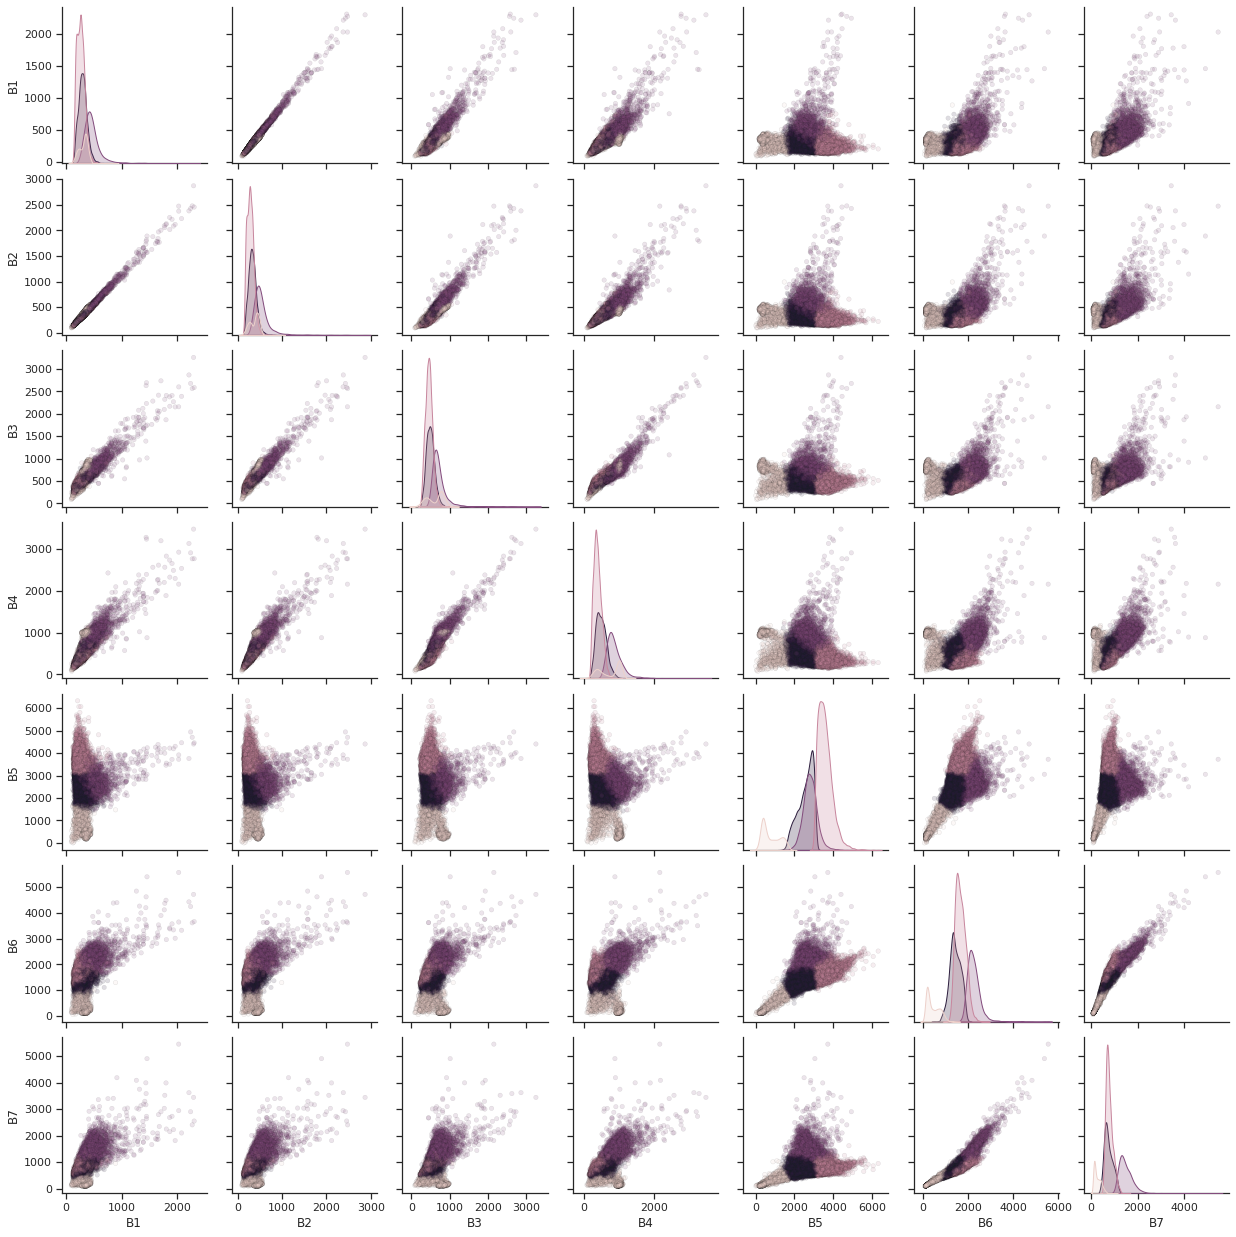

In [ ]:
# sample random subset of images
imagesamples = []
for i in range(Nsamples):
    xr=np.random.randint(0,imagecube[2].shape[1]-1)
    yr=np.random.randint(0,imagecube[2].shape[0]-1)
    imagesamples.append(imagecube[2][yr,xr,:])
imagesamples = np.array(imagesamples)
KM_train = kmeans(imagesamples, centroids_init[2])
i=0
for k in KM_train:
    KM_train[i] = str(k) 
    i=i+1
#convert to pandas dataframe
imagessamplesDF = pd.DataFrame(imagesamples,columns = band_names)
imagessamplesDF['group'] = KM_train
# pair plots with clusters coloured:
pp2=sns.pairplot(imagessamplesDF,vars=band_names, hue='group',plot_kws = seaborn_params_p)
pp2._legend.remove()

Loops = 43


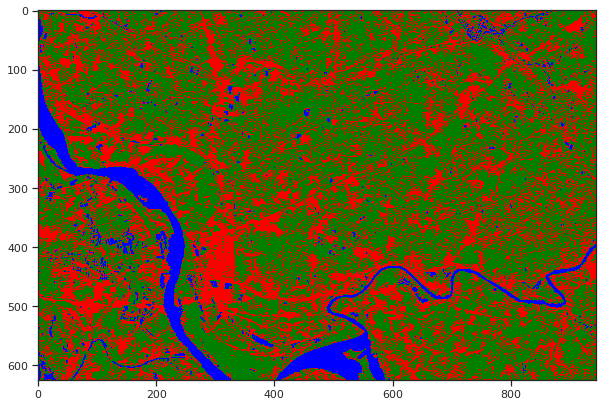

In [ ]:
#  make the clustered image
imagecube_scaled = imagecube[2].reshape(-1,7)
imageclustered = kmeans(imagecube_scaled, centroids_init[2])
# plot the map of the clustered data
np.array(imageclustered)
imageclustered = imageclustered.reshape(imagecube[2].shape[0], imagecube[2].shape[1])
plt.figure(figsize=thefigsize)
plt.imshow(imageclustered, cmap=ListedColormap(['blue', 'green', 'red', 'green']))

In [ ]:
plt.imsave('/content/drive/MyDrive/landcover/analysis/2021/Hy_classification_codebyme.jpg', imageclustered, cmap=ListedColormap(['blue','green','red','green']))

In [ ]:
band_combinations = np.array([[4, 3, 2], [7, 6, 4], [5, 4, 3], [6, 5, 2], [5, 6, 4], [6, 5, 4]])
print(band_combinations)

[[4 3 2]
 [7 6 4]
 [5 4 3]
 [6 5 2]
 [5 6 4]
 [6 5 4]]


Loops = 82
Loops = 40
Loops = 68
Loops = 95
Loops = 100
Loops = 100


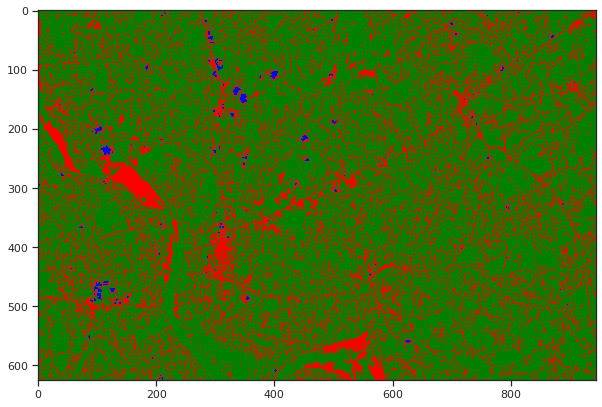

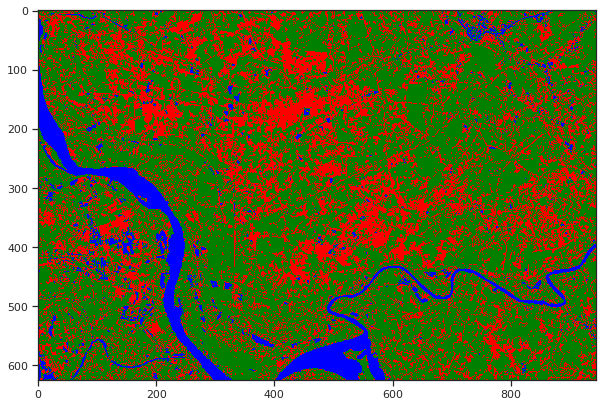

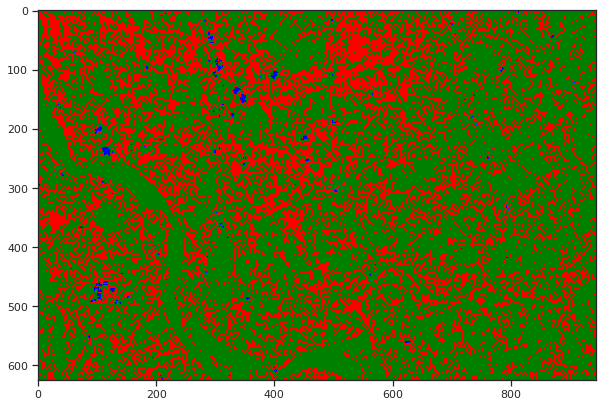

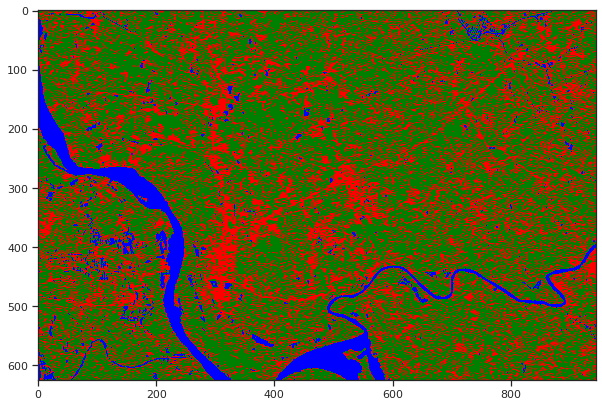

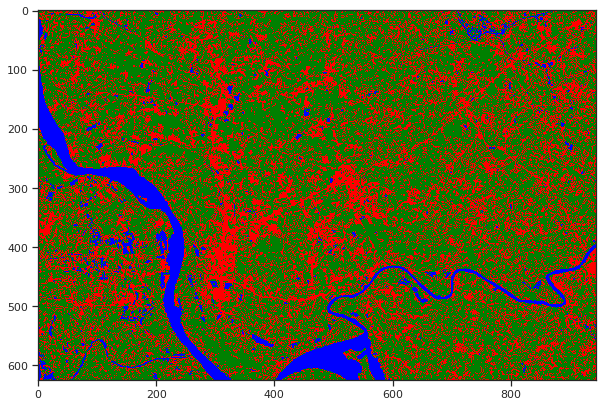

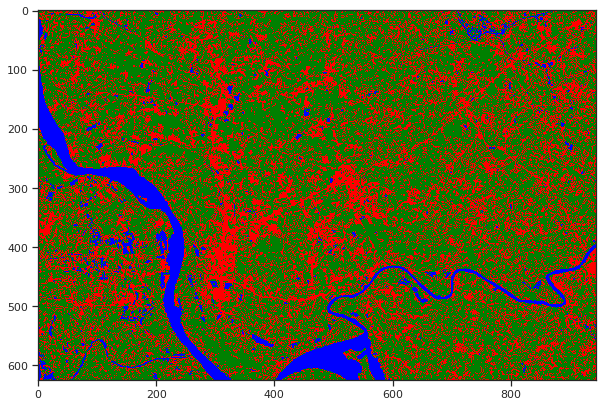

In [ ]:
data_labels = []
for i in range(band_combinations.shape[0]):
  band = band_combinations[i] - 1
  data = imagecube_scaled[:, (band[0]-1, band[1]-1, band[2]-1)]
  centroid = centroids_init[2][:, (band[0]-1, band[1]-1, band[2]-1)]
  imageclustered = kmeans(data, centroid)
  data_labels.append(imageclustered)
  # plot the map of the clustered data
  np.array(imageclustered)
  imageclustered = imageclustered.reshape(imagecube[2].shape[0], imagecube[2].shape[1])
  plt.figure(figsize=thefigsize)
  plt.imshow(imageclustered, cmap=ListedColormap(['blue', 'green', 'red', 'green']))

In [ ]:
data_labels = np.array(data_labels)
print(data_labels)

[[2 2 2 ... 3 3 2]
 [3 1 3 ... 3 3 2]
 [3 3 3 ... 2 2 3]
 [3 1 3 ... 3 2 2]
 [2 1 3 ... 3 2 2]
 [2 1 3 ... 3 2 2]]


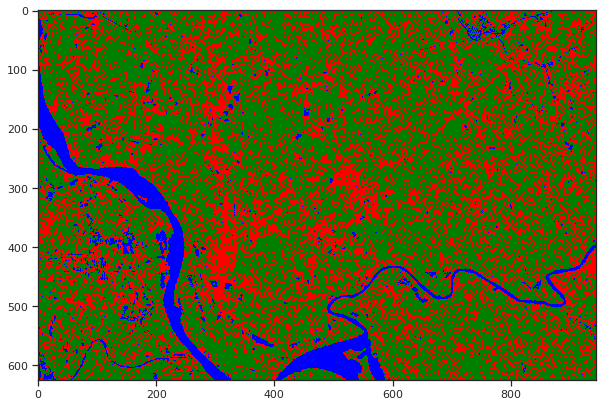

In [ ]:
last_image = []
for i in range(data_labels.shape[1]):
  temp = [0]*4
  for label, band in zip(data_labels, band_combinations):
    temp[label[i]] = temp[label[i]] + 1
    if np.array_equal(band, [7, 6, 4]) and label[i] == 2:
      temp[label[i]] = temp[label[i]] + 1
    elif np.array_equal(band, [6, 5, 2]) and label[i] in (1, 3):
      temp[label[i]] = temp[label[i]] + 1
    elif np.array_equal(band, [5, 6, 4]) and label[i] == 0:
      temp[label[i]] = temp[label[i]] + 1 
  last_image.append(temp.index(max(temp)))
# plot the map of the clustered data
last_image = np.array(last_image)
last_image = last_image.reshape(imagecube[2].shape[0], imagecube[2].shape[1])
plt.figure(figsize=thefigsize)
plt.imshow(last_image, cmap=ListedColormap(['blue','green','red','green']))

In [ ]:
plt.imsave('/content/drive/MyDrive/landcover/analysis/2021/Hy_classification_plusplus.jpg', imageclustered, cmap=ListedColormap(['blue','green','red','green']))

Loops = 47
Loops = 75
Loops = 43


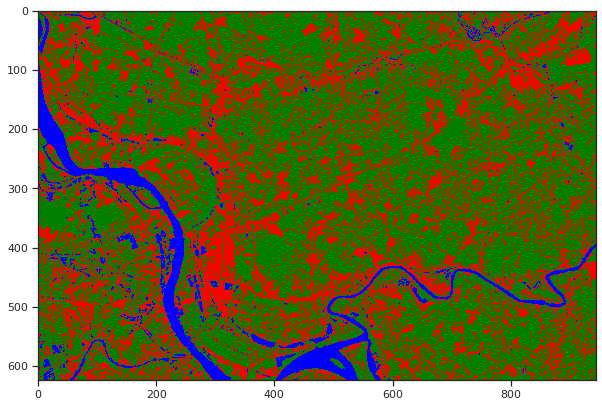

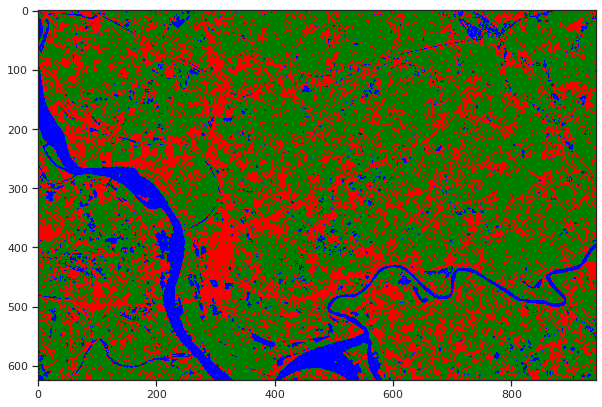

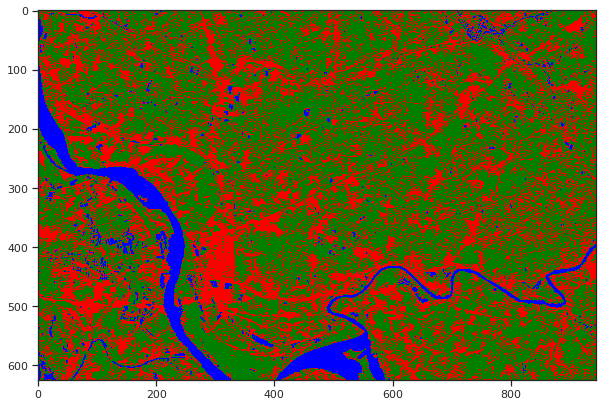

In [ ]:
count_to_analysis = []
for i in range(np.size(folder_name)):
    #  make the clustered image
    imagecube_scaled = imagecube[i].reshape(-1,7)
    imageclustered = kmeans(imagecube_scaled, centroids_init[i])
    # plot the map of the clustered data
    count = [0]*3
    for j in imageclustered:
      if(j==0):
        count[0] = count[0] + 1
      elif(j==2):
        count[1] = count[1] + 1
      else:
        count[2] = count[2] + 1
    count_to_analysis.append(count)
    np.array(imageclustered)
    imageclustered = imageclustered.reshape(imagecube[i].shape[0], imagecube[i].shape[1])
    plt.figure(figsize=thefigsize)
    plt.imshow(imageclustered, cmap=ListedColormap(['blue', 'green', 'red', 'green']))

In [ ]:
count_to_analysis = np.array(count_to_analysis)
print(count_to_analysis)

[[ 44022 106229 439749]
 [ 42564 126266 420545]
 [ 47300 127366 416278]]


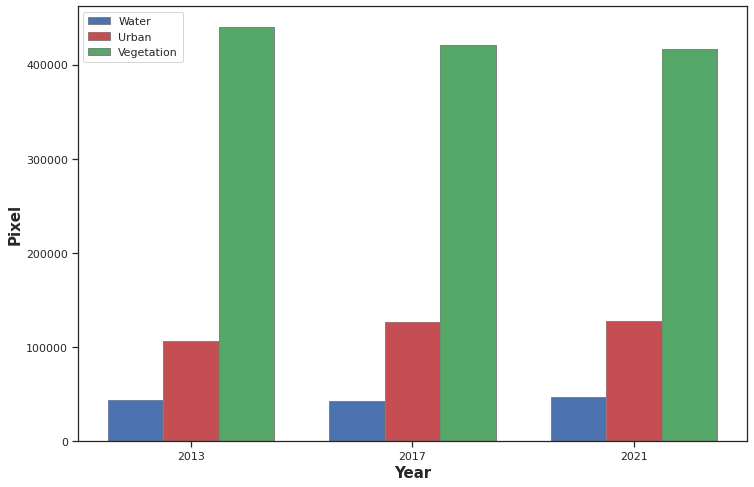

In [ ]:
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))

# set height of bar
water = count_to_analysis[:,0]
urban = count_to_analysis[:,1]
vegetation = count_to_analysis[:,2]

# Set position of bar on X axis
br1 = np.arange(len(water))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

# Make the plot
plt.bar(br1, water, color ='b', width = barWidth,
		edgecolor ='grey', label ='Water')
plt.bar(br2, urban, color ='r', width = barWidth,
		edgecolor ='grey', label ='Urban')
plt.bar(br3, vegetation, color ='g', width = barWidth,
		edgecolor ='grey', label ='Vegetation')

# Adding Xticks
plt.xlabel('Year', fontweight ='bold', fontsize = 15)
plt.ylabel('Pixel', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(water))],['2013', '2017', '2021'])

plt.legend()
plt.show()